In [1]:
import os
import gzip
import pickle
import requests
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
import torch.quantization as quant
from torch.quantization.observer import MovingAverageMinMaxObserver
from torch.quantization.fake_quantize import FakeQuantize


In [2]:
# Download & load MNIST
data_dir = Path("data/mnist")
data_dir.mkdir(parents=True, exist_ok=True)
url = "https://github.com/pytorch/tutorials/raw/main/_static/mnist.pkl.gz"
fpath = data_dir / "mnist.pkl.gz"
if not fpath.exists():
    print("Downloading MNIST dataset...")
    fpath.write_bytes(requests.get(url).content)
with gzip.open(fpath, "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
# Convert to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.long)
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Valid: {x_valid.shape}, {y_valid.shape}")

Train: torch.Size([50000, 784]), torch.Size([50000])
Valid: torch.Size([10000, 784]), torch.Size([10000])


In [5]:

# Data augmentation & DataLoader definitions
normalize = transforms.Normalize((0.1307,), (0.3081,))
train_transforms = transforms.Compose([
    transforms.ToTensor(), normalize,
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
])
valid_transforms = transforms.Compose([transforms.ToTensor(), normalize])

class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images, self.labels, self.transform = images, labels, transform
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        img = self.images[idx].view(28,28).numpy()
        img = self.transform(img) if self.transform else torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        return img, self.labels[idx]

batch_size = 64
train_dl = DataLoader(MNISTDataset(x_train, y_train, transform=train_transforms), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(MNISTDataset(x_valid, y_valid, transform=valid_transforms), batch_size=batch_size*2)
print(f"Batches: train={len(train_dl)}, valid={len(valid_dl)}")


Batches: train=782, valid=79


In [2]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Set FBGEMM backend
torch.backends.quantized.engine = 'fbgemm'

# Define a Quantized‐ready wrapper with stubs
class QuantizedMnistCNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.quant = quant.QuantStub()
        self.dequant = quant.DeQuantStub()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(32, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(32, 16, 3, 2, 1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Conv2d(16, 10, 3, 1, 1), nn.BatchNorm2d(10), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        )

    def forward(self, x):
        x = self.quant(x)
        x = self.net(x)
        x = self.dequant(x)
        return x

In [34]:
# Reload float32 model and fuse Conv-BN-ReLU blocks
teacher = QuantizedMnistCNN2().to('cpu')
float_ckpt = torch.load("mnist_cnn2_final.pth", map_location='cpu')
# load only the 'net.' keys
teacher_state = {k: v for k, v in float_ckpt.items() if k.startswith("net.")}
teacher.load_state_dict(teacher_state, strict=False)
teacher.eval()
quant.fuse_modules(
    teacher.net,
    [
      ["0","1","2"],
      ["4","5","6"],
      ["8","9","10"],
      ["11","12","13"]
    ],
    inplace=True
)

# Build custom QAT config (explicit quant_min/quant_max)
teacher.train()
qat_qconfig = quant.QConfig(
    activation=FakeQuantize.with_args(
        observer=MovingAverageMinMaxObserver,
        quant_min=0, quant_max=255,
        dtype=torch.quint8, qscheme=torch.per_tensor_affine
    ),
    weight=FakeQuantize.with_args(
        observer=MovingAverageMinMaxObserver,
        quant_min=-128, quant_max=127,
        dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
    )
)
teacher.qconfig = qat_qconfig
quant.prepare_qat(teacher, inplace=True)

# Fine-tune QAT for a few epochs
optimizer = optim.SGD(teacher.parameters(), lr=1e-3, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
for epoch in range(5):
    teacher.train()
    running = 0.0
    for xb, yb in train_dl:  # MNIST DataLoader
        optimizer.zero_grad()
        preds = teacher(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    print(f"QAT Epoch {epoch+1}: loss={running/len(train_dl.dataset):.4f}")

# 5) Convert to fully quantized INT8
teacher.eval()
quantized_model = quant.convert(teacher, inplace=False)

# 6) Script & save
scripted = torch.jit.script(quantized_model)
scripted.save("mnist_cnn2_int8_scripted.pt")

# 7) Sanity-check directly with FloatTensor input
x_val = ((x_valid - 0.1307)/0.3081).view(-1,1,28,28)
with torch.no_grad():
    logits = scripted(x_val)             
    preds  = logits.argmax(dim=1).numpy()
print("Quantized teacher accuracy:", accuracy_score(y_valid.numpy(), preds).round(4))


QAT Epoch 1: loss=0.1331
QAT Epoch 2: loss=0.1300
QAT Epoch 3: loss=0.1251
QAT Epoch 4: loss=0.1244
QAT Epoch 5: loss=0.1232
Quantized teacher accuracy: 0.9838


**Prediction Instance on The Quantized Model**

Overall Test Accuracy: 98.38%
122


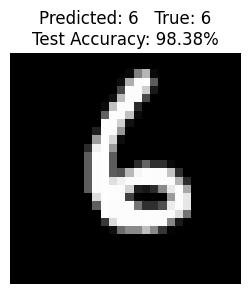

In [4]:

import matplotlib.pyplot as plt


# using the same quant backend
torch.backends.quantized.engine = 'fbgemm'

# 1) Load the INT8 model
model = torch.jit.load("mnist_int8.pt", map_location=device)
model.eval()

# 2) Preprocess the validation set exactly as in training
mean, std = 0.1307, 0.3081
x_norm = (x_valid - mean) / std
x_norm = x_norm.view(-1, 1, 28, 28)  # → [10000,1,28,28]

# 3) Run a full‐batch inference
with torch.no_grad():
    logits = model(x_norm.to(device))         
    preds  = logits.argmax(dim=1).cpu().numpy()

# 4) Compute overall accuracy
y_true      = y_valid.cpu().numpy()
overall_acc = accuracy_score(y_true, preds)
print(f"Overall Test Accuracy: {overall_acc:.2%}")

# 5) Visualize a single example
i = 122  
print(i)
img    = x_norm[i].squeeze().cpu().numpy()   # [28,28]
pred_i = preds[i]
true_i = int(y_valid[i].item())

plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(
    f"Predicted: {pred_i}   True: {true_i}\n"
    f"Test Accuracy: {overall_acc:.2%}",
    fontsize=12
)
plt.show()
